# TD 2 - Exercise 1
### This exercise aims to generate a random variable having a discrete distribution

In [254]:
import numpy as np
from numpy.random import uniform, randn
from random import randint
import matplotlib.pyplot as plt
from scipy.stats import norm, truncnorm, geom, poisson, binom, multivariate_normal

In [255]:
def sample_from_discrete(pdf, n_samples, show_graphs=True):
    """
    Generates a distribution of variables following a certain discrete 
    preset distribution, and plots the result
    Parameters :
    - pdf: probability density function to emulate
    - n_samples (int): how many samples to generate. The higher, the closer their
        repartition will match the sampled distribution.
    """
    cdf = pdf.cumsum() # cumulative distribution : a sort of histogram
    samples = np.random.uniform(size=n_samples)
    associated_bin = np.array(np.searchsorted(cdf, samples, side='right') - 1)

    # Plotting the ordeal
    if show_graphs == False : 
        return associated_bin
    fig = plt.plot(np.arange(len(cdf)),cdf, label='Cumulative DF')
    fig = plt.plot(np.arange(len(pdf)),pdf, label='Probability DF')
    plt.legend()
    plt.title('Density function')
    plt.show()
    plt.clf()

    fig, axes, = plt.subplots(1,2,figsize=(10,5))
    axes[0].set_title("Theoretical distribution")
    axes[0].bar(abs,pdf,color='red')
    axes[0].set_xlim([0,20])
    axes[0].xaxis.set_ticks(range(20))

    axes[1].set_xlim([0,20])
    axes[1].xaxis.set_ticks(range(20))
    axes[1].set_title("Sampled distribution")
    axes[1].hist(associated_bin,bins=np.arange(20) ,color="blue", width=0.8, density=True)
    plt.show()
    
    return associated_bin

Let us now test the algorithm with a well-known discrete law :  $\mathcal{B}\textit(n,p)$ with *n*=20 and *p*=0.7

[3.48678440e-11 1.62716605e-09 3.60688475e-08 5.04963865e-07
 5.00755833e-06 3.73897689e-05 2.18106985e-04 1.01783260e-03
 3.85928193e-03 1.20066549e-02 3.08170809e-02 6.53695655e-02
 1.14396740e-01 1.64261985e-01 1.91638983e-01 1.78863051e-01
 1.30420974e-01 7.16036722e-02 2.78458725e-02 6.83933711e-03]


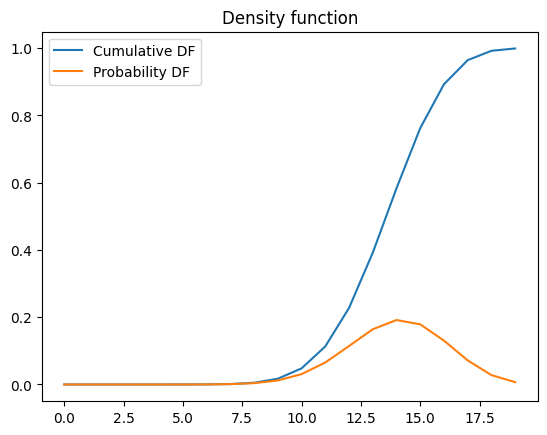

<Figure size 640x480 with 0 Axes>

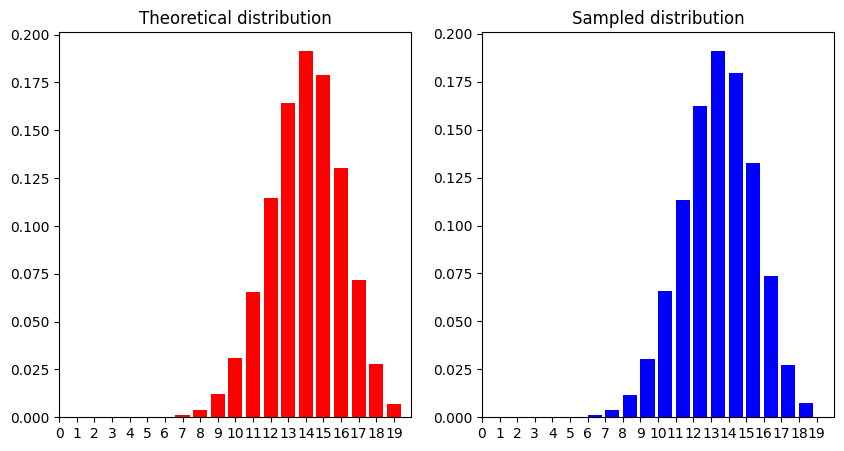

array([11, 10, 11, ...,  9, 17, 15], dtype=int64)

In [256]:
# Testing the algorithm
N=20
p=0.7
abs=np.arange(N)
pdf = binom.pmf(abs,N, p)
print(pdf)
sample_from_discrete(pdf, 100000)

## TD 2 - Exercise 2
### The goal of this exercise is to better understand the EM algo in the context of GMMs

2.1) 
We are asked to write the likelihood of a GMM made up of a n-sample of *i.i.d* variables $(X_i)$. We can identify two types of parameters :

- Firstly, there are the parameters of each Gaussian $(\mu, \Sigma)_j$ with $j\in [0,...,m]$
- Then, there are the model weights, dictating the interaction between each Gaussian and their relative importance $(\alpha_j)_j$ with $j\in [0,...,m]$

Thus we can define our parameters $\theta$ = $(\mu, \Sigma, \alpha)_j$
Our likelihood is of the form: 
$$
\begin{align*}
\mathcal{L}(x, \theta) &= \prod_{i=1}^n p(x|\theta) \\
&= \prod_{i=1}^n \sum_{j=1}^m \alpha_j \mathcal{N}(x; \mu_j, \Sigma_j) \text(i.i.d.)

\end{align*} $$


2.2) Sample from a Gaussian mixture law

We will 

In [257]:
# Generate parameters
SEED=1
np.random.seed = SEED

def generate_sampling_parameters(dimension,n_clusters):
    mu=np.random.uniform(-5, 5, (n_clusters,dimension))
    sigma=np.random.uniform(-2,2,(n_clusters,dimension,dimension))
    sigma = sigma @ sigma.transpose(0, 2, 1) # Assuring that the covariance matrices are positive semi-definite

    alpha=np.full(n_clusters, 1/n_clusters) # Uniform distrib
    return mu, sigma, alpha

In [258]:
# Sampling from GMM
def sample_from_GMM(alpha,mu,sigma,n_samples):
    """
    Parameters : 
    - alpha(np.array(n_samples)): distribution to sample from
    - mu(np.array(n_samples, d)): mean vector for all Gaussians
    - sigma(np.array(n_samples, d, d)): covariance matrices for all Gaussians
    """
    tau=sample_from_discrete(alpha,n_samples,show_graphs=False)
    means=mu[tau]
    covs=sigma[tau]

    points=np.zeros((n_samples, DIMENSIONS))
    for i in range(n_samples):
        points[i]=np.random.multivariate_normal(means[i],covs[i])
    return tau, points

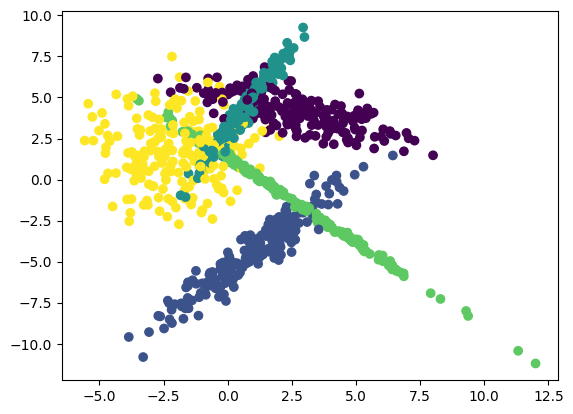

In [259]:
# Let us restrict ourselves to 2 dimensions : 
DIMENSIONS = 2
CLUSTERS = 5
N_SAMPLES = 1000

mu_2d, sigma_2d, alpha_2d = generate_sampling_parameters(dimension=DIMENSIONS,n_clusters=CLUSTERS)
tau_2d, points_2d = sample_from_GMM(alpha_2d,mu_2d,sigma_2d, N_SAMPLES)
plt.scatter(points_2d[:,0],points_2d[:,1], c=tau_2d)


3.3) Implementing EM

In [260]:
print(alpha_2d,mu_2d,sigma_2d)

[0.2 0.2 0.2 0.2 0.2] [[ 0.90650158 -4.48473224]
 [ 0.54789378  4.09354263]
 [ 2.18223524 -0.92307656]
 [-2.16063668  1.67054358]
 [ 2.47229518  4.242717  ]] [[[ 2.93844361  3.25661731]
  [ 3.25661731  4.01347987]]

 [[ 0.80123498  1.640938  ]
  [ 1.640938    3.54650581]]

 [[ 6.98425564 -7.21610744]
  [-7.21610744  7.47196937]]

 [[ 2.90432506  0.31358685]
  [ 0.31358685  3.85346374]]

 [[ 4.42273576 -1.80245523]
  [-1.80245523  1.26897554]]]


In [261]:
# Implement EM

def e_step(alpha, mu, sigma, n_samples, points):
    """
    Parameters : 
    - alpha: np.array() (n_clusters,)
    - mu: np.array(n_clusters,n_dimensions)
    - sigma: np.array(n_clusters, n_dimensions, n_dimensions)
    - n_samples: int
    - points: np.array(n_samples, dimensions) in this case, 2-dimensional
    """
    tau = np.zeros((n_samples, CLUSTERS))
    realisation = np.zeros((n_samples, CLUSTERS))
    # print(sigma)
    for k in range(CLUSTERS):
        density = multivariate_normal(mean=mu[k], cov=sigma[k])
        # print(f"sigmaK={sigma[k]}")
        tau[:, k] = alpha[k] * density.pdf(points)
        tau /= np.sum(tau, axis=1, keepdims=True)
        # tau /= CLUSTERS
    return tau

def m_step(tau, points):
    """
    Parameters :
    - tau: np.array(n_samples, n_clusters)
    - points: np.array(n_samples, dimensions) in this case, 2-dimensional
    - n_clusters: int
    """
    nk=np.sum(tau,axis=0)
    n_samples=points.shape[0]
    alpha_hat = nk/n_samples # (n_clusters,)
    mu_hat = (tau.T@points) / nk[:, np.newaxis] # (n_clusters, dimenstions)
    sigma_hat = np.zeros((tau.shape[1], points.shape[1], points.shape[1]))  # (n_components, d, d)

    for k in range(tau.shape[1]):
        diff = points - mu_hat[k]
        sigma_hat[k] = np.dot(tau[:, k] * diff.T, diff) / np.sum(tau[:, k])
        sigma_hat[k] += 1e-6 * np.eye(points.shape[1])

    return alpha_hat, mu_hat, sigma_hat

def log_likelihood(alpha, mu, sigma, points, n_samples):
    n_samples = points.shape[0]
    n_clusters = alpha.shape[0]
    log_likelihood_value = 0

    for i in range(n_samples):
        mixture_density = 0
        for k in range(n_clusters):
            density = multivariate_normal.pdf(points[i],mean=mu[k], cov=sigma[k])
            mixture_density += alpha[k] * density
        
        log_likelihood_value += np.log(mixture_density)
    
    return log_likelihood_value



In [262]:
def generate_responsibilities(n_samples, n_clusters):
    responsibilities = np.random.rand(n_samples, n_clusters)
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    return responsibilities

# initial_tau = generate_responsibilities(N_SAMPLES, CLUSTERS)
# alpha_test, mu_test, sigma_test = m_step(initial_tau,N_SAMPLES, points_2d)
# (n_samples,n_clusters) = points_2d.shape
# print((n_samples,n_clusters), )

In [314]:
MAX_STEPS = 100
def EM_algorithm(points, n_clusters, epsilon):
    """
    """
    n_samples=points.shape[0]
    previous_log=0.
    initial_tau = generate_responsibilities(n_samples, n_clusters)
    alpha, mu, sigma = m_step(initial_tau, points)
    tau = e_step(alpha_2d, mu_2d, sigma_2d, n_samples, points)
    print("Initialisation réussie \n")
    print(np.mean(tau, axis=0))
    for i in range(MAX_STEPS-1):
        if i%10 == 1 :
            print(f"\nTour n°{i}")
        alpha, mu, sigma = m_step(tau, points)
        tau = e_step(alpha, mu, sigma, n_samples, points)
        # current_log=log_likelihood(alpha, mu, sigma, points, n_samples)
        # if np.abs(previous_log - current_log) <= epsilon : 
        #     print(f"Convergence attained on step {i}")
        #     print(f"\nMu={mu}\nSigma={sigma}")
        #     return tau
        # print(f"Current precision : {current_log-previous_log}")
        # previous_log = current_log 
    
    print(f"Convergence not attained on step {MAX_STEPS}")
    print(f"\nMu={mu}\nSigma={sigma}")
    return tau

Initialisation réussie 

[0.97733028 0.00903728 0.009146   0.00173297 0.00275347]

Tour n°1

Tour n°11

Tour n°21

Tour n°31

Tour n°41

Tour n°51

Tour n°61

Tour n°71

Tour n°81

Tour n°91
Convergence not attained on step 100

Mu=[[ 0.93999364  0.72548755]
 [ 1.0611969   5.31976594]
 [ 3.05416378 -1.90616676]
 [ 0.03741796  3.06977357]
 [ 0.90267672  4.90147476]]
Sigma=[[[ 6.42575489e+000 -9.39228838e-001]
  [-9.39228838e-001  1.54513097e+001]]

 [[ 2.46080009e-004  6.23638099e-004]
  [ 6.23638099e-004  1.58792861e-003]]

 [[ 1.00000000e-006  6.24178534e-207]
  [ 6.24178534e-207  1.00000000e-006]]

 [[ 3.48050559e-004  7.58926852e-004]
  [ 7.58926852e-004  1.66061400e-003]]

 [[ 1.54334776e-004  1.53397287e-004]
  [ 1.53397287e-004  1.54459824e-004]]]


Text(0.5, 1.0, 'Predictions')

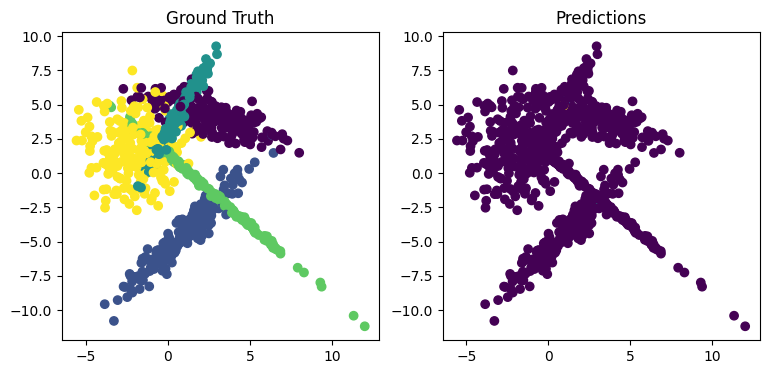

In [316]:
tau_final=(EM_algorithm(points_2d, CLUSTERS, 10e-5))
fig, axes=plt.subplots(1,2,figsize=(9,4))        
axes[0].scatter(points_2d[:,0],points_2d[:,1], c=tau_2d)
axes[0].set_title("Ground Truth")
axes[1].scatter(points_2d[:,0],points_2d[:,1], c=np.argmax(tau_final, axis=1))
axes[1].set_title("Predictions")

In [317]:
alpha_final= np.mean(tau_final, axis=0)
print(alpha_final)

[9.94095176e-01 1.55660489e-03 9.93716815e-04 1.53595027e-03
 1.81855203e-03]


# TD 2 - Exercise 3
### This exercise aims to better understand Montecarlo sampling procedure

3.1) Implementing poor importance sampling

In [318]:
# introducing work functions
def p(x):
    return np.power(x,0.65)*np.exp(-(np.square(x))/2) * (x>=0)

def q(x,mean=0.8):
    gauss= norm(mean,np.sqrt(1.5))
    return 2*gauss.pdf(x)

def f(x):
    return 2*np.sin(x*(np.pi)/1.5)


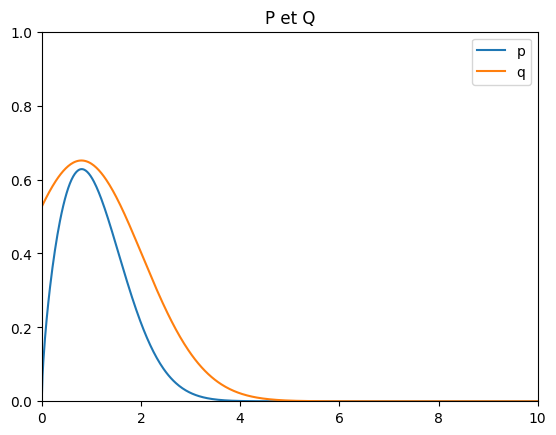

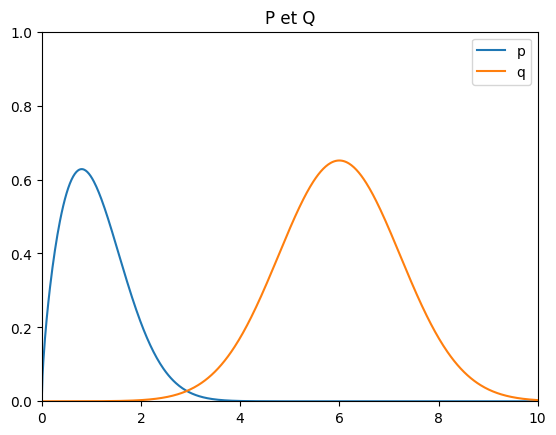

In [319]:
def plot_data(x,y_list,title):
    """
    x (array-like): The x-axis values.
    y_list (list of tuples): A list of (y, label) tuples, where each y is an array of y-values
                             and label is a string for the legend.
    title (str): The title of the plot.
    """
    plt.figure()
    plt.title(title)
    for y, label in y_list:
        plt.plot(x, y, label=label)
    plt.xlim([0, 10])
    plt.ylim([0, 1])
    plt.legend()
abs = np.linspace(0,10,600)
samplep=[]
sampleq1=[]
sampleq2=[]
for i in range(600):
    samplep.append(p(abs[i]))
    sampleq1.append(q(abs[i],0.8))
    sampleq2.append(q(abs[i],6))
plot_data(abs,[(samplep,('p')),(sampleq1,('q'))],'P et Q')
plot_data(abs,[(samplep,('p')),(sampleq2,('q'))],'P et Q')

2) Computing mean and variance of the estimator

In [320]:
# Compute the expectation of f 

def create_q_sample(n,n_samples=int, mean=0.8,var=1.5):
    """
    Generates a matrix of size (n, n_samples) of random values in a truncated 
    normal law
    """
    a,b = 0, np.inf
    sigma = np.sqrt(var)
    a = (a - mean) / sigma
    b = (b - mean) / sigma
    distrib=truncnorm(a,b,loc=mean,scale=sigma)
    samples = distrib.rvs((n, n_samples))
    return samples

def estimator(f,p,q,sample,mean=0.8):
    """ 
    - f (function): The function whose expectation we are estimating.
    - p (function): The probability density function of the initial distribution.
    - q (function): The probability density function of the optimized reference distribution.
    - samples (numpy array of shape (n, n_samples)): 
      Samples drawn from the distribution q, where each row represents a set of samples.
    """
    x=sample
    f_x,p_x,q_x=f(x),p(x),q(x,mean)
    weights = (p_x/q_x)
    weights /= np.mean(weights, axis=1, keepdims=True)
    return np.mean(f_x*weights, axis=1)

In [321]:
N= [10, 100, 1000, 10000]
n = 500

means = np.zeros(len(N))
variances = np.zeros(len(N))
for i, n_samples in enumerate(N):
     x = create_q_sample(n,n_samples)
     sampled = estimator(f,p,q,x)
     means[i] = sampled.mean()
     variances[i] = sampled.var()

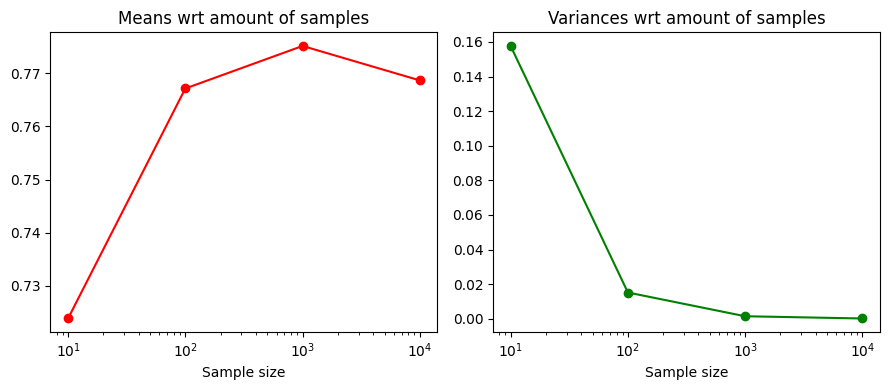

In [322]:
# Show graphically
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
ax1.plot(N, means, c='red',marker='o')
ax1.set_title('Means wrt amount of samples')
ax1.set_xlabel('Sample size')
ax1.set_xscale('log')
ax2.plot(N, variances, c='green', marker='o')
ax2.set_title('Variances wrt amount of samples')    
ax2.set_xlabel('Sample size')
ax2.set_xscale('log')
plt.tight_layout()
plt.show()

### 3) Changing the value of *q*

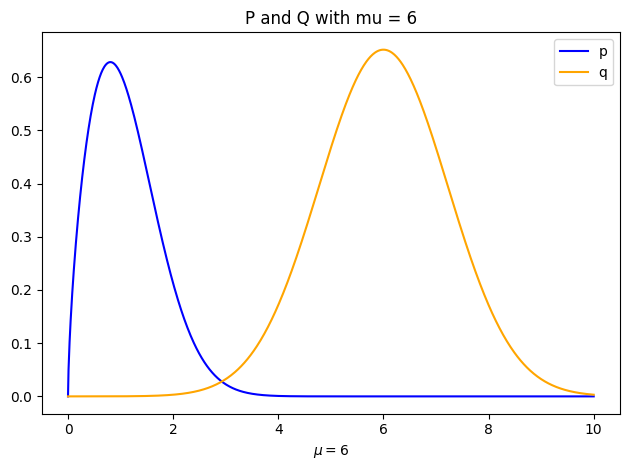

In [323]:
abs = np.linspace(0,10,1000)
plt.plot(abs,p(abs),c='blue',label='p')
plt.plot(abs,q(abs,6),c='orange',label='q')
title="P and Q with mu = 6"
plt.title(title)
plt.xlabel(r'$\mu=6$')
plt.legend()
plt.tight_layout()
plt.show()

In [324]:
N= [10, 100, 1000, 10000]
n = 500

means = np.zeros(len(N))
variances = np.zeros(len(N))
for i, n_samples in enumerate(N):
     x = create_q_sample(n,n_samples, mean=6)
     sampled = estimator(f,p,q,x, mean = 6) # changed the mean parameter from 0.8 to 6
     means[i] = sampled.mean()
     variances[i] = sampled.var()

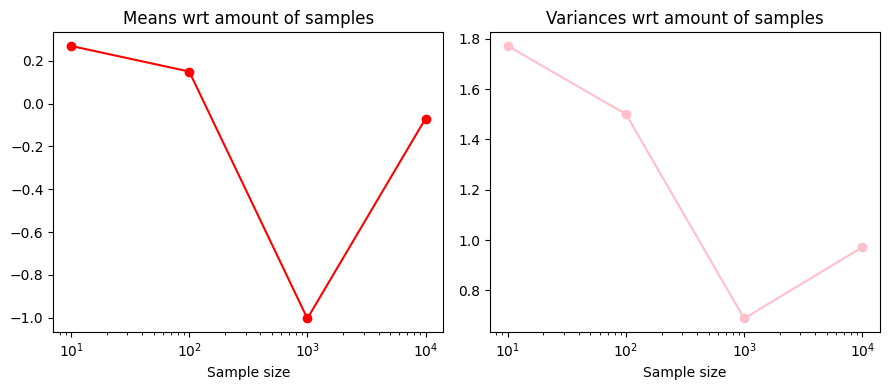

In [325]:
# Show graphically
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
ax1.plot(N, means, c='red',marker='o')
ax1.set_title('Means wrt amount of samples')
ax1.set_xlabel('Sample size')
ax1.set_xscale('log')
ax2.plot(N, variances, c='pink', marker='o')
ax2.set_title('Variances wrt amount of samples')    
ax2.set_xlabel('Sample size')
ax2.set_xscale('log')
plt.tight_layout()
plt.show()

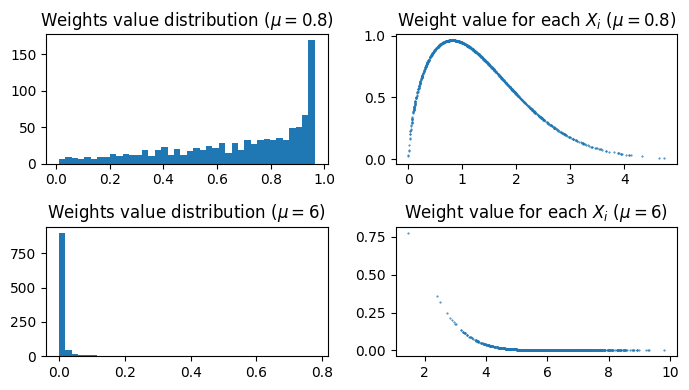

In [326]:
N = 1000
means = [0.8, 6]

weights = np.zeros((2, N))
x_vals = np.zeros_like(weights)

for i, mean in enumerate(means):
    x = create_q_sample(1, N, mean=mean)    
    weights[i] = p(x)/q(x)
    x_vals[i] = x

fig, ax = plt.subplots(2, 2, figsize=(7,4))
for i, mean in enumerate(means):
    ax[i][0].hist(weights[i], bins=40)
    ax[i][0].set_title(rf'Weights value distribution ($\mu=${mean})')
    ax[i][1].scatter(x_vals[i], weights[i], s=.2)
    ax[i][1].set_title(rf'Weight value for each $X_i$ ($\mu=${mean})')
plt.tight_layout()
plt.show()
